# Part 4: Natures Trend Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Get the Trend Dataset
link = 'https://drive.google.com/file/d/1-3MtTOQ4HWAkMXYIrNKFTsBH8L3_PPqL/view'

# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Trend Dataset.csv')

data = pd.read_csv('Trend Dataset.csv')

# 6. Natures Trend Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77172 entries, 0 to 77171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EventDate            77172 non-null  object 
 1   Employer             77172 non-null  object 
 2   City                 77172 non-null  object 
 3   State                77172 non-null  object 
 4   Zip                  77172 non-null  float64
 5   Primary NAICS        77172 non-null  int64  
 6   Nature               77172 non-null  int64  
 7   NatureTitle          77172 non-null  object 
 8   Part of Body         77172 non-null  int64  
 9   Part of Body Title   77172 non-null  object 
 10  Event                77172 non-null  int64  
 11  EventTitle           77172 non-null  object 
 12  Source               77172 non-null  int64  
 13  SourceTitle          77172 non-null  object 
 14  Event DayOfWeek      77172 non-null  object 
 15  Event Day            77172 non-null 

In [8]:
data['NatureTitle'].value_counts().head(10)

Fractures                                                     24661
Amputations                                                   20433
Soreness, pain, hurt-nonspecified injury                       5815
Cuts, lacerations                                              3814
Traumatic injuries and disorders, unspecified                  1661
Intracranial injuries, unspecified                             1615
Crushing injuries                                              1519
Heat (thermal) burns, unspecified                              1475
Internal injuries to organs and blood vessels of the trunk     1322
Puncture wounds, except gunshot wounds                         1130
Name: NatureTitle, dtype: int64

In [9]:
# Install pmdarima
%pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00


## 6.1 All Natures

In [10]:
from pmdarima.arima import auto_arima

data['EventDate'] = pd.to_datetime(data['EventDate'])
monthly_counts = data.groupby(data['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1083.556, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1076.891, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1074.993, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1081.589, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1070.193, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1071.652, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1071.861, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1073.876, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1078.436, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1068.394, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1073.018, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1074.914, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1069.899, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

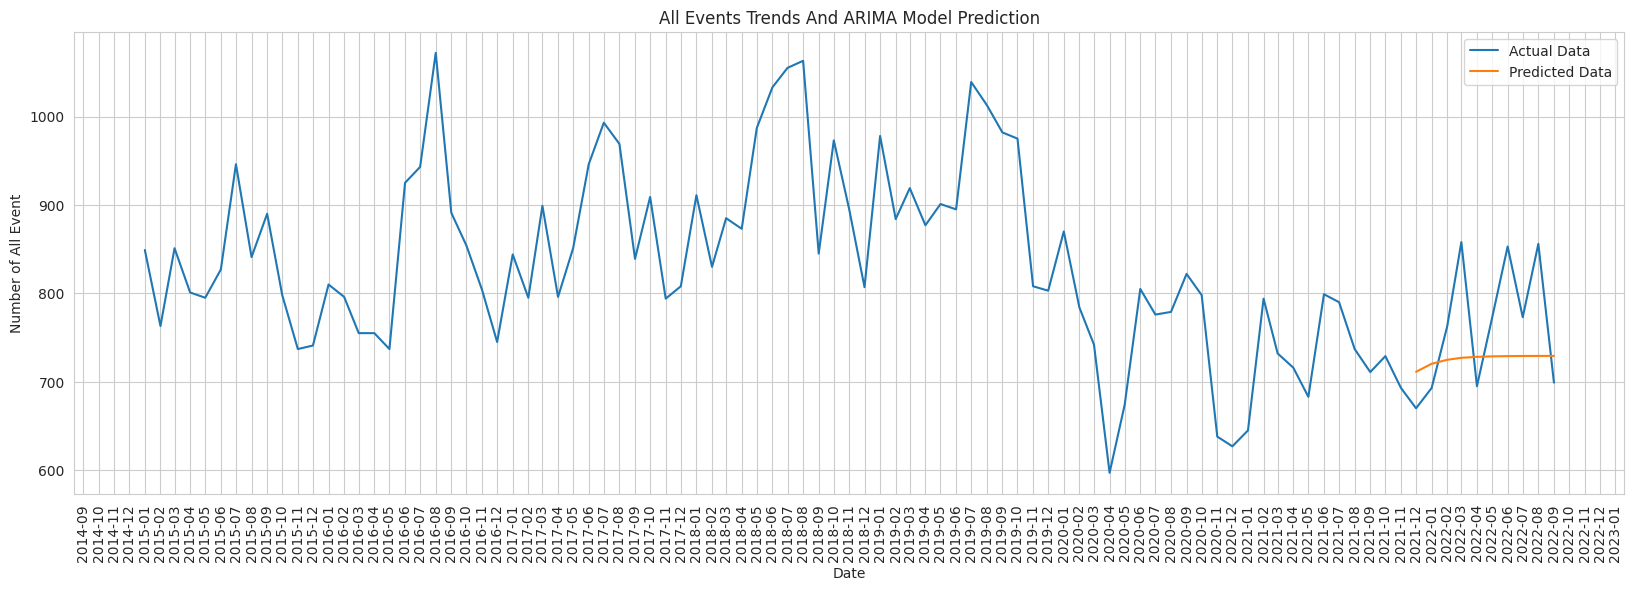

Mean Absolute Error: 63.89821014289678
Mean Squared Error: 5829.4093466538925
Root Mean Squared Error: 76.35056873824773
R-squared: -0.21
MAPE: 8.01%
Theil's U statistic: 0.7947494714879138


In [11]:
from statsmodels.tsa.arima.model import ARIMA

data['EventDate'] = pd.to_datetime(data['EventDate'])
monthly_counts = data.groupby(data['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of All Event')
plt.title('All Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.2 Fractures

In [12]:
from pmdarima.arima import auto_arima

Fractures = data[data['NatureTitle'] == 'Fractures']
Fractures['EventDate'] = pd.to_datetime(Fractures['EventDate'])
monthly_counts = Fractures.groupby(Fractures['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

<ipython-input-12-6e4110446caf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fractures['EventDate'] = pd.to_datetime(Fractures['EventDate'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=914.186, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=901.291, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=890.367, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=912.207, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=891.107, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=891.192, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=888.819, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=889.623, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=889.703, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=899.364, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=891.622, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.513 seconds
Best order: (0, 1, 1)


<ipython-input-15-2ac7df2c1d2d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fractures['EventDate'] = pd.to_datetime(Fractures['EventDate'])


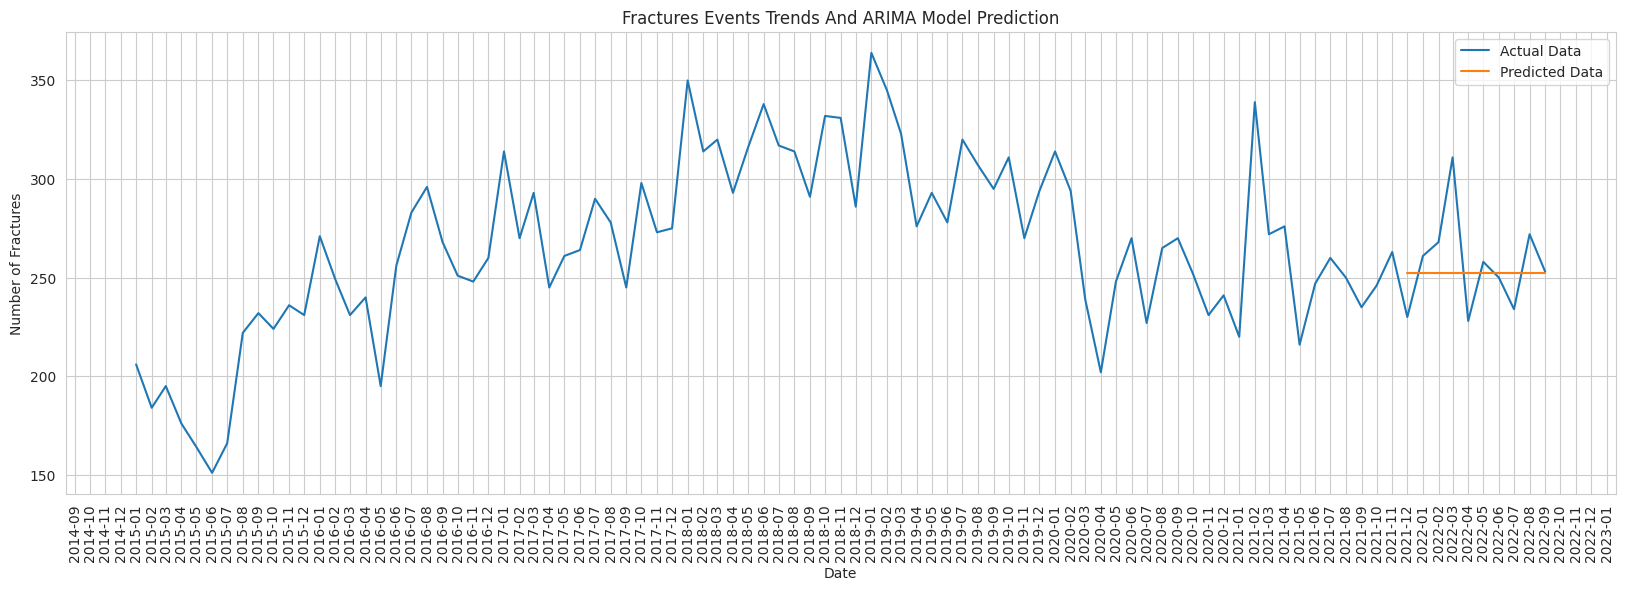

Mean Absolute Error: 17.633046896892903
Mean Squared Error: 561.3991783105723
Root Mean Squared Error: 23.69386372693513
R-squared: -0.03
MAPE: 6.69%
Theil's U statistic: 0.6496469660570432


In [15]:
from statsmodels.tsa.arima.model import ARIMA

Fractures = data[data['NatureTitle'] == 'Fractures']
Fractures['EventDate'] = pd.to_datetime(Fractures['EventDate'])
monthly_counts = Fractures.groupby(Fractures['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(0, 1, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Fractures')
plt.title('Fractures Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.3 Amputations

In [16]:
from pmdarima.arima import auto_arima

Amputations = data[data['NatureTitle'] == 'Amputations']
Amputations['EventDate'] = pd.to_datetime(Amputations['EventDate'])
monthly_counts = Amputations.groupby(Amputations['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

<ipython-input-16-b9a4f042c0c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amputations['EventDate'] = pd.to_datetime(Amputations['EventDate'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=861.961, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=894.290, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=866.235, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=856.271, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=892.312, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=858.253, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=858.261, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=860.253, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=854.459, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=856.456, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=856.457, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=864.260, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=858.422, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.749 seconds
Best order: (0, 1, 1)


<ipython-input-17-03cba0cabd63>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amputations['EventDate'] = pd.to_datetime(Amputations['EventDate'])


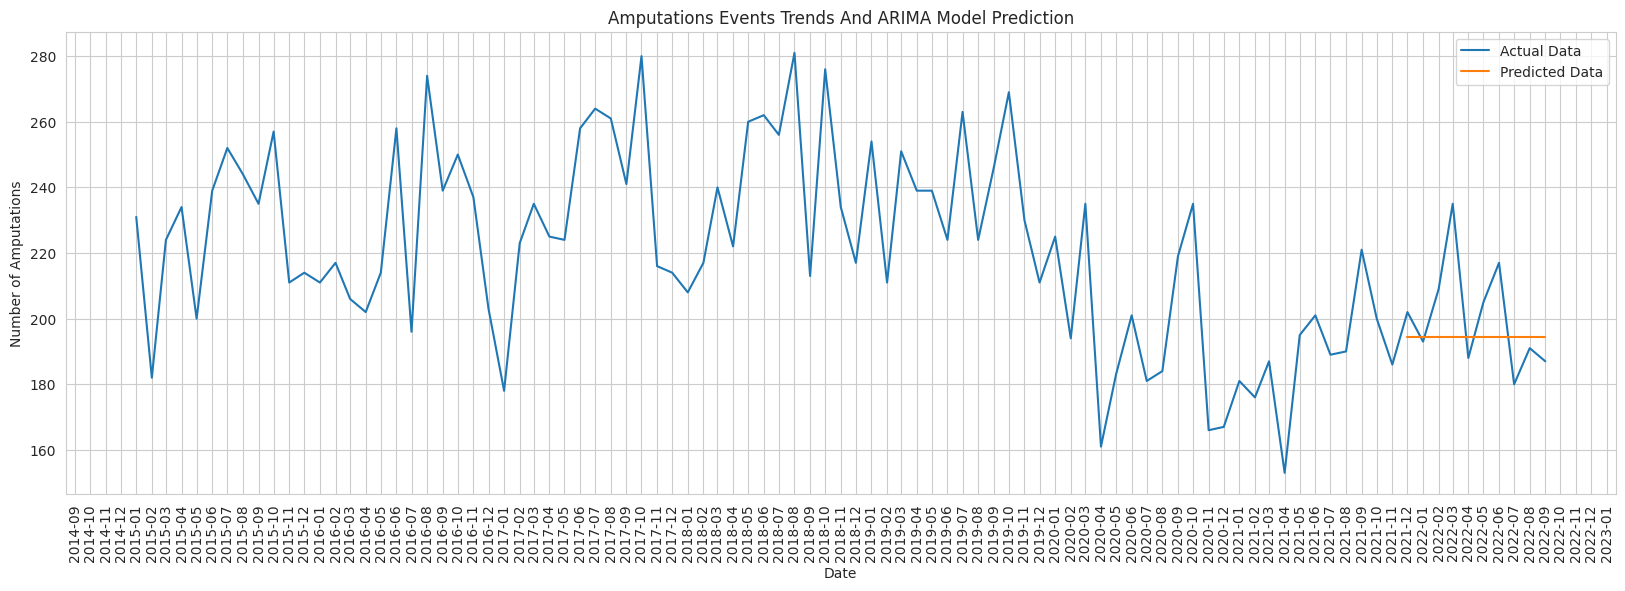

Mean Absolute Error: 12.9
Mean Squared Error: 284.5894901645834
Root Mean Squared Error: 16.869780382820146
R-squared: -0.16
MAPE: 6.15%
Theil's U statistic: 0.7269026536022078


In [17]:
from statsmodels.tsa.arima.model import ARIMA

Amputations = data[data['NatureTitle'] == 'Amputations']
Amputations['EventDate'] = pd.to_datetime(Amputations['EventDate'])
monthly_counts = Amputations.groupby(Amputations['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(0, 1, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Amputations')
plt.title('Amputations Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.4 Soreness, Pain, Hurt-Nonspecified Injury

In [18]:
from pmdarima.arima import auto_arima

SPHI = data[data['NatureTitle'] == 'Soreness, pain, hurt-nonspecified injury']
SPHI['EventDate'] = pd.to_datetime(SPHI['EventDate'])
monthly_counts = SPHI.groupby(SPHI['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

<ipython-input-18-79ae5935d215>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPHI['EventDate'] = pd.to_datetime(SPHI['EventDate'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=715.394, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=740.303, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=717.282, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=711.331, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=738.582, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=713.275, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=713.292, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=714.926, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=711.497, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.947 seconds
Best order: (0, 1, 1)


<ipython-input-19-b56db0348bef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPHI['EventDate'] = pd.to_datetime(SPHI['EventDate'])


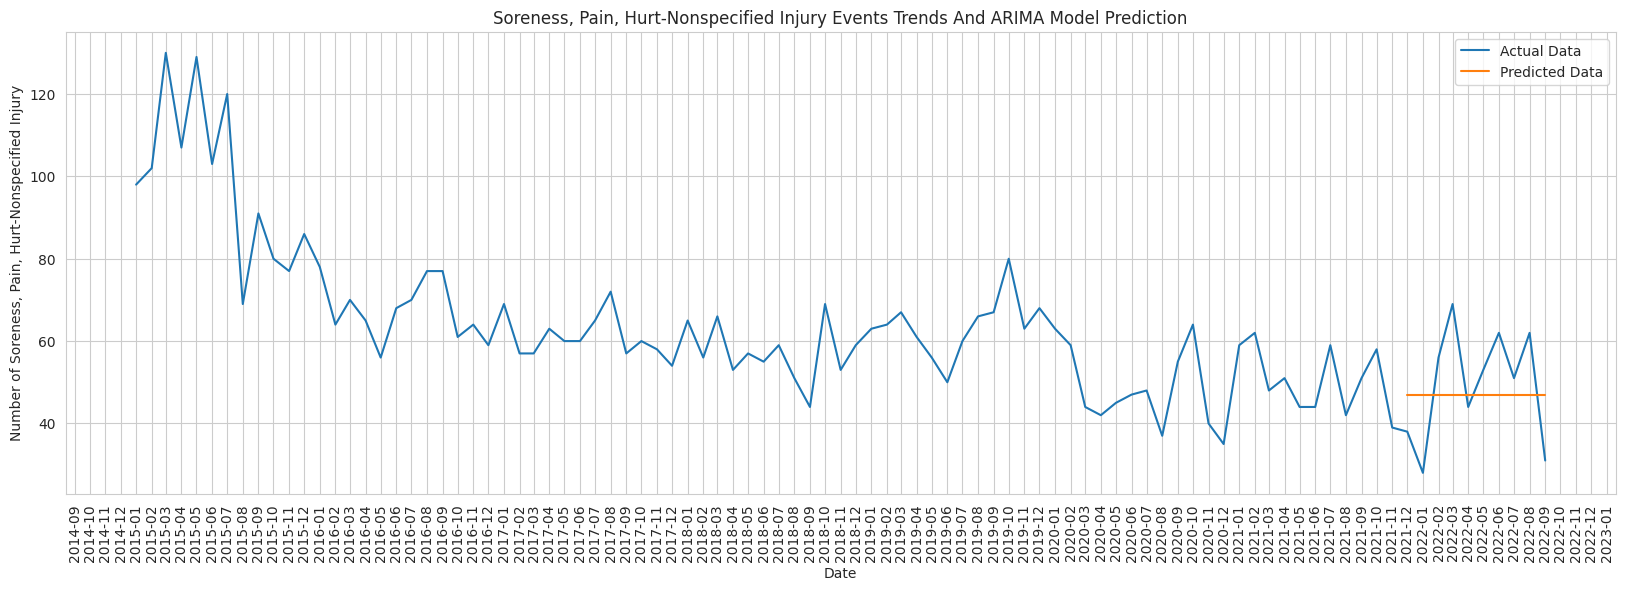

Mean Absolute Error: 11.818950168143036
Mean Squared Error: 177.8637817572491
Root Mean Squared Error: 13.336558092598295
R-squared: -0.04
MAPE: 26.53%
Theil's U statistic: 0.7584448704196481


In [19]:
from statsmodels.tsa.arima.model import ARIMA

SPHI = data[data['NatureTitle'] == 'Soreness, pain, hurt-nonspecified injury']
SPHI['EventDate'] = pd.to_datetime(SPHI['EventDate'])
monthly_counts = SPHI.groupby(SPHI['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(0, 1, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Soreness, Pain, Hurt-Nonspecified Injury')
plt.title('Soreness, Pain, Hurt-Nonspecified Injury Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.5 Cuts, Lacerations

In [20]:
from pmdarima.arima import auto_arima

CL = data[data['NatureTitle'] == 'Cuts, lacerations']
CL['EventDate'] = pd.to_datetime(CL['EventDate'])
monthly_counts = CL.groupby(CL['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

Performing stepwise search to minimize aic


<ipython-input-20-0b51159b8d1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CL['EventDate'] = pd.to_datetime(CL['EventDate'])


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=665.972, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=960.910, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=678.578, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=872.590, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=662.433, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=812.619, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=663.216, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=653.579, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=654.674, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=654.518, Time=0.22 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=754.424, Time=0.17 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=648.535, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=646.883, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept

<ipython-input-21-99eb218d08e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CL['EventDate'] = pd.to_datetime(CL['EventDate'])


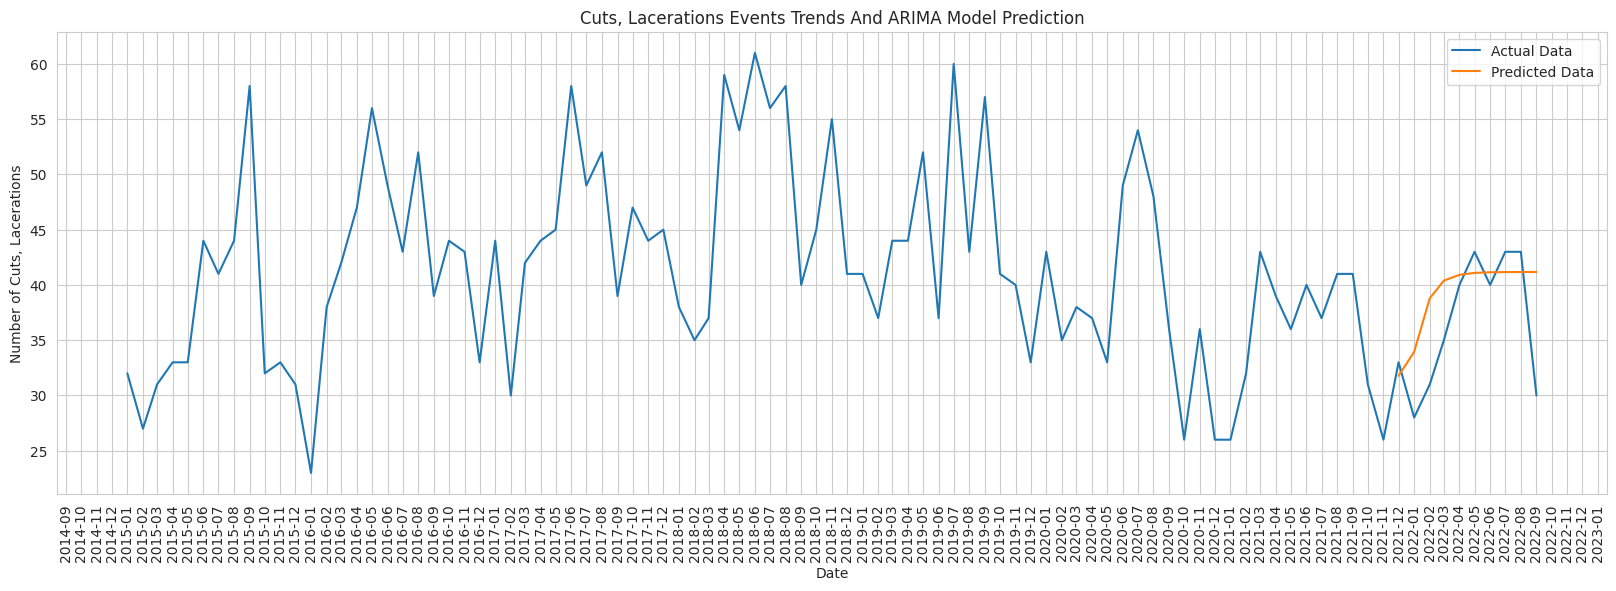

Mean Absolute Error: 3.9168093012566985
Mean Squared Error: 26.40553547739058
Root Mean Squared Error: 5.138631673645288
R-squared: 0.15
MAPE: 12.09%
Theil's U statistic: 0.9711101062589325


In [21]:
from statsmodels.tsa.arima.model import ARIMA

CL = data[data['NatureTitle'] == 'Cuts, lacerations']
CL['EventDate'] = pd.to_datetime(CL['EventDate'])
monthly_counts = CL.groupby(CL['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(1, 0, 2))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Cuts, Lacerations')
plt.title('Cuts, Lacerations Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.6 Traumatic Injuries And Disorders, Unspecified

In [22]:
from pmdarima.arima import auto_arima

TIDU = data[data['NatureTitle'] == 'Traumatic injuries and disorders, unspecified']
TIDU['EventDate'] = pd.to_datetime(TIDU['EventDate'])
monthly_counts = TIDU.groupby(TIDU['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

<ipython-input-22-4390a96a882d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TIDU['EventDate'] = pd.to_datetime(TIDU['EventDate'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=647.347, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=644.912, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=646.897, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=646.895, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=644.681, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=648.432, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.295 seconds
Best order: (0, 1, 0)


<ipython-input-23-70248f1f14f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TIDU['EventDate'] = pd.to_datetime(TIDU['EventDate'])


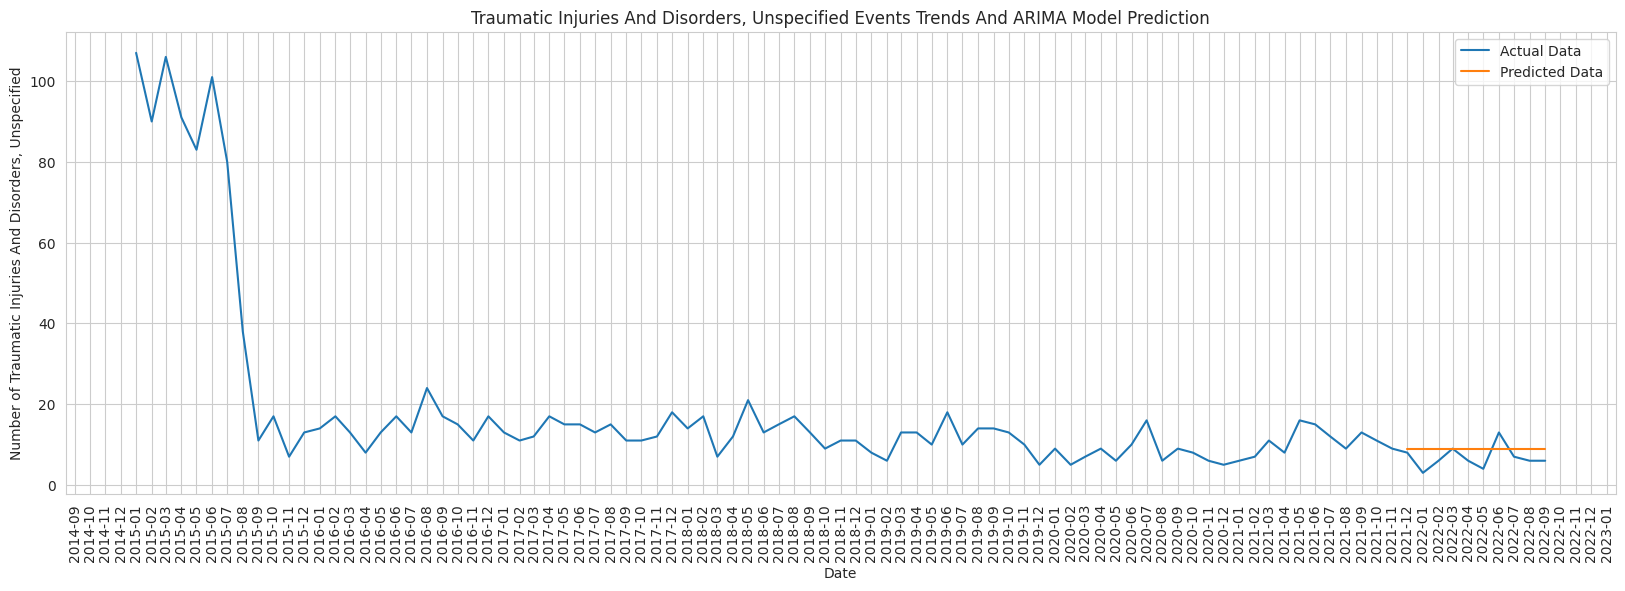

Mean Absolute Error: 3.0
Mean Squared Error: 11.8
Root Mean Squared Error: 3.4351128074635335
R-squared: -0.70
MAPE: 59.68%
Theil's U statistic: 0.8141998208760591


In [23]:
from statsmodels.tsa.arima.model import ARIMA

TIDU = data[data['NatureTitle'] == 'Traumatic injuries and disorders, unspecified']
TIDU['EventDate'] = pd.to_datetime(TIDU['EventDate'])
monthly_counts = TIDU.groupby(TIDU['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(0, 1, 0))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Traumatic Injuries And Disorders, Unspecified')
plt.title('Traumatic Injuries And Disorders, Unspecified Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.7 Intracranial Injuries, Unspecified

In [24]:
from pmdarima.arima import auto_arima

IIU = data[data['NatureTitle'] == 'Intracranial injuries, unspecified']
IIU['EventDate'] = pd.to_datetime(IIU['EventDate'])
monthly_counts = IIU.groupby(IIU['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

Performing stepwise search to minimize aic


<ipython-input-24-d14083fce1e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IIU['EventDate'] = pd.to_datetime(IIU['EventDate'])


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=605.013, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=594.626, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=603.035, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=586.894, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=585.463, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=586.438, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=583.723, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=585.080, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=584.756, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=576.616, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=574

<ipython-input-25-b2f40247ffb8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IIU['EventDate'] = pd.to_datetime(IIU['EventDate'])


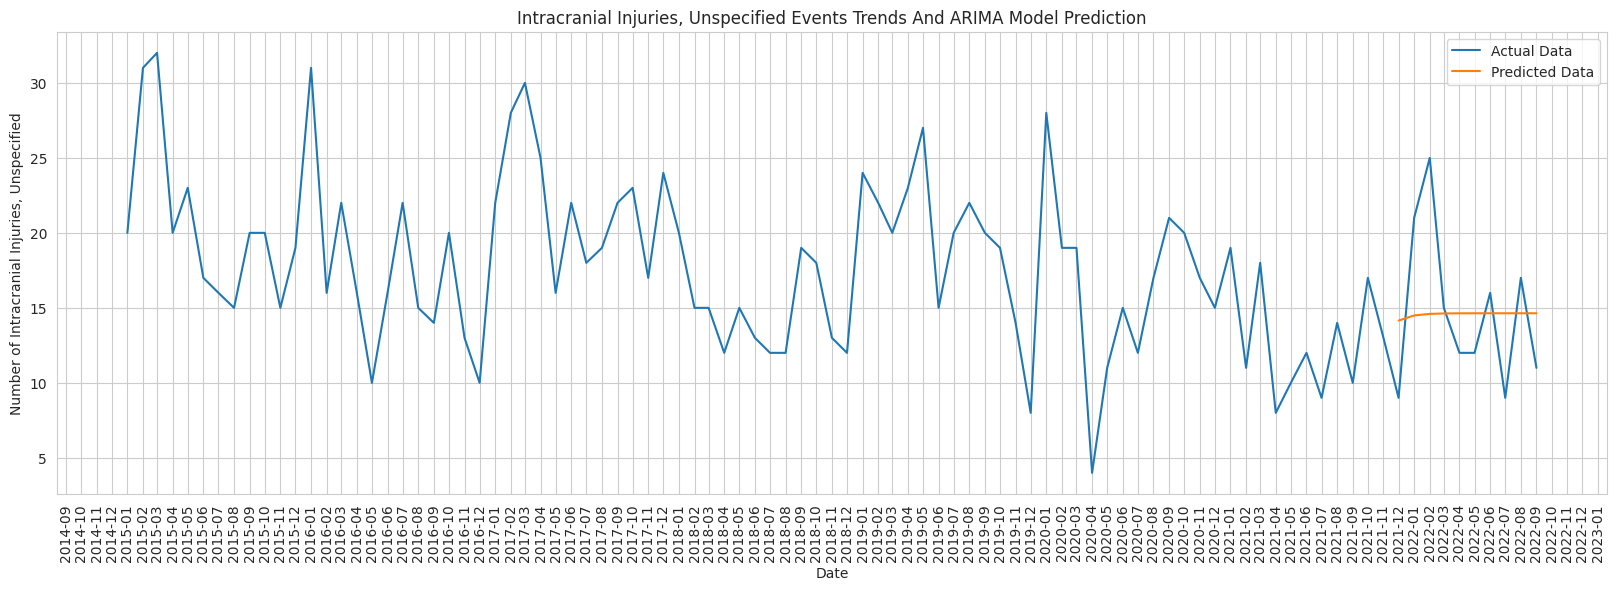

Mean Absolute Error: 4.070872212127705
Mean Squared Error: 24.36218269769716
Root Mean Squared Error: 4.935806185183648
R-squared: 0.01
MAPE: 29.44%
Theil's U statistic: 0.7457977050396448


In [25]:
from statsmodels.tsa.arima.model import ARIMA

IIU = data[data['NatureTitle'] == 'Intracranial injuries, unspecified']
IIU['EventDate'] = pd.to_datetime(IIU['EventDate'])
monthly_counts = IIU.groupby(IIU['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Intracranial Injuries, Unspecified')
plt.title('Intracranial Injuries, Unspecified Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.8 Crushing Injuries

In [26]:
from pmdarima.arima import auto_arima

CI = data[data['NatureTitle'] == 'Crushing injuries']
CI['EventDate'] = pd.to_datetime(CI['EventDate'])
monthly_counts = CI.groupby(CI['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

Performing stepwise search to minimize aic


<ipython-input-26-32bb70a65942>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CI['EventDate'] = pd.to_datetime(CI['EventDate'])


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=584.088, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=549.940, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=537.074, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=582.089, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=539.068, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=539.070, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=540.653, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=535.091, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=537.089, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=537.090, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=547.941, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=538.660, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.148 seconds
Best order: (0, 1, 1)


<ipython-input-27-5e0c1cd41342>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CI['EventDate'] = pd.to_datetime(CI['EventDate'])


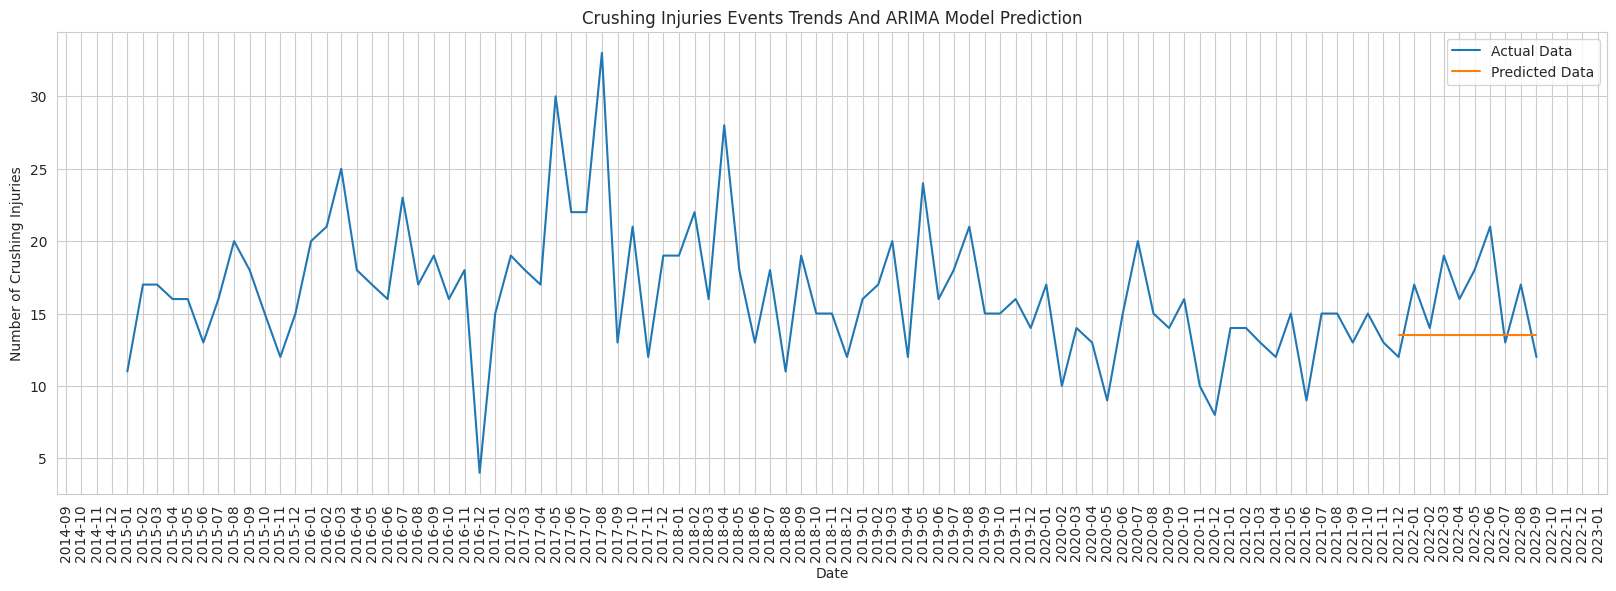

Mean Absolute Error: 3.0835128589505745
Mean Squared Error: 14.053853218781791
Root Mean Squared Error: 3.748846918557997
R-squared: -0.66
MAPE: 17.82%
Theil's U statistic: 0.8692430651929975


In [27]:
from statsmodels.tsa.arima.model import ARIMA

CI = data[data['NatureTitle'] == 'Crushing injuries']
CI['EventDate'] = pd.to_datetime(CI['EventDate'])
monthly_counts = CI.groupby(CI['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(0, 1, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Crushing Injuries')
plt.title('Crushing Injuries Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.9 Heat (Thermal) Burns, Unspecified

In [28]:
from pmdarima.arima import auto_arima

HBU = data[data['NatureTitle'] == 'Heat (thermal) burns, unspecified']
HBU['EventDate'] = pd.to_datetime(HBU['EventDate'])
monthly_counts = HBU.groupby(HBU['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

<ipython-input-28-81be271dd5e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HBU['EventDate'] = pd.to_datetime(HBU['EventDate'])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=788.862, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=608.764, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=718.411, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=589.609, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=583.320, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=568.407, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=567.498, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=567.272, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=567.923, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=567.260, Time=0.54 sec
 A

<ipython-input-29-9c1e1e9c9827>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HBU['EventDate'] = pd.to_datetime(HBU['EventDate'])


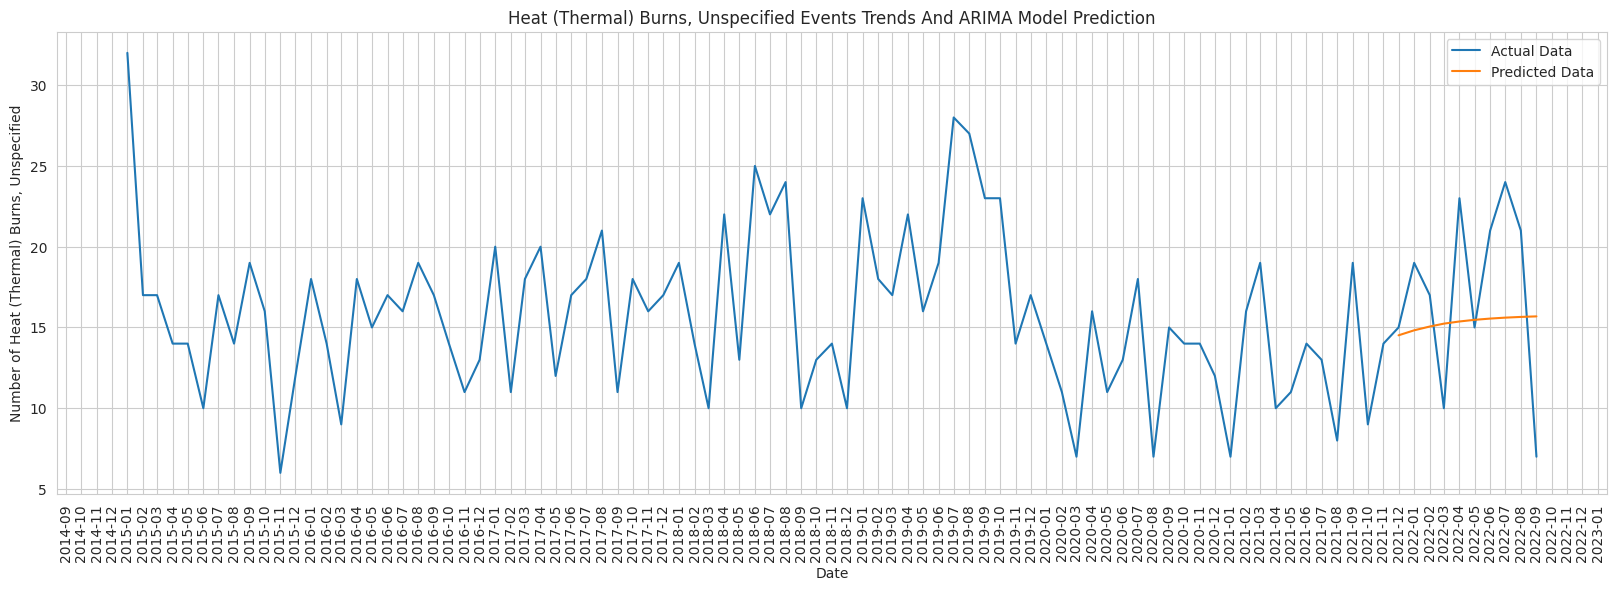

Mean Absolute Error: 4.7817245475346315
Mean Squared Error: 31.146696938816728
Root Mean Squared Error: 5.5809225884988525
R-squared: -0.12
MAPE: 33.58%
Theil's U statistic: 0.7110753807148108


In [29]:
from statsmodels.tsa.arima.model import ARIMA

HBU = data[data['NatureTitle'] == 'Heat (thermal) burns, unspecified']
HBU['EventDate'] = pd.to_datetime(HBU['EventDate'])
monthly_counts = HBU.groupby(HBU['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(1, 0, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Heat (Thermal) Burns, Unspecified')
plt.title('Heat (Thermal) Burns, Unspecified Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.10 Internal Injuries To Organs And Blood Vessels Of The Trunk

In [30]:
from pmdarima.arima import auto_arima

IIOBVT = data[data['NatureTitle'] == 'Internal injuries to organs and blood vessels of the trunk']
IIOBVT['EventDate'] = pd.to_datetime(IIOBVT['EventDate'])
monthly_counts = IIOBVT.groupby(IIOBVT['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

Performing stepwise search to minimize aic


<ipython-input-30-8edddacd8810>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IIOBVT['EventDate'] = pd.to_datetime(IIOBVT['EventDate'])


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=547.222, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=769.695, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=578.865, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=700.433, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=545.721, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=653.779, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=543.895, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=545.677, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=553.679, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=540.968, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=554.218, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=549.082, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=542.183, Time=0.61 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=542.213, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=559.988, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] i

<ipython-input-31-d732aae15972>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IIOBVT['EventDate'] = pd.to_datetime(IIOBVT['EventDate'])


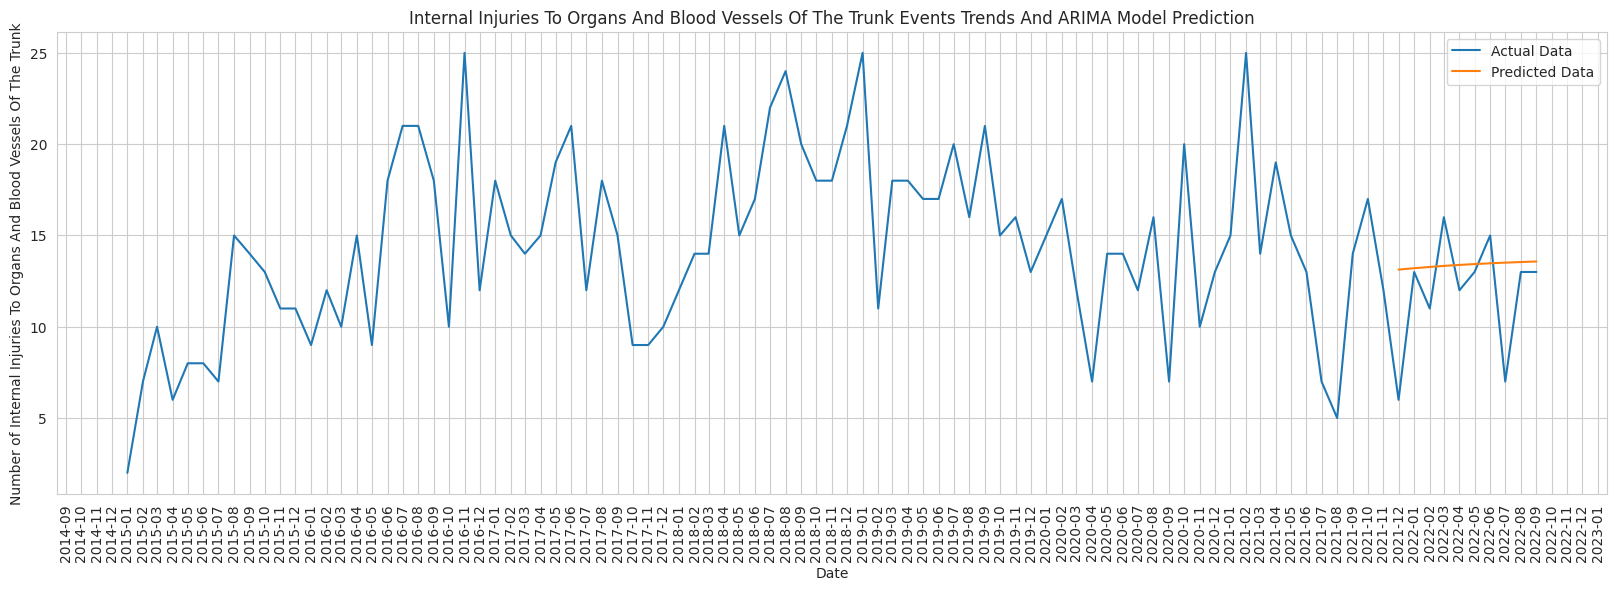

Mean Absolute Error: 2.3250767010113456
Mean Squared Error: 11.062633491860186
Root Mean Squared Error: 3.326053741577274
R-squared: -0.22
MAPE: 28.44%
Theil's U statistic: 0.667887663550836


In [31]:
from statsmodels.tsa.arima.model import ARIMA

IIOBVT = data[data['NatureTitle'] == 'Internal injuries to organs and blood vessels of the trunk']
IIOBVT['EventDate'] = pd.to_datetime(IIOBVT['EventDate'])
monthly_counts = IIOBVT.groupby(IIOBVT['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(1, 0, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Internal Injuries To Organs And Blood Vessels Of The Trunk')
plt.title('Internal Injuries To Organs And Blood Vessels Of The Trunk Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

## 6.11 Puncture Wounds, Except Gunshot Wounds

In [32]:
from pmdarima.arima import auto_arima

PWGW = data[data['NatureTitle'] == 'Puncture wounds, except gunshot wounds']
PWGW['EventDate'] = pd.to_datetime(PWGW['EventDate'])
monthly_counts = PWGW.groupby(PWGW['EventDate'].dt.to_period('M')).size()

# Fit the ARIMA model using auto_arima
model = auto_arima(monthly_counts, seasonal=False, trace=True)

# Get the order (p, d, q) of the best-fit model
p, d, q = model.order
print('Best order: ({}, {}, {})'.format(p, d, q))

<ipython-input-32-f4b01c1843c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PWGW['EventDate'] = pd.to_datetime(PWGW['EventDate'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=546.453, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=532.793, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=531.320, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=544.458, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=529.329, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=520.459, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=530.795, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=533.529, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=521.507, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=524.544, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=532.246, Time=0.05 se

<ipython-input-33-6450efa52941>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PWGW['EventDate'] = pd.to_datetime(PWGW['EventDate'])


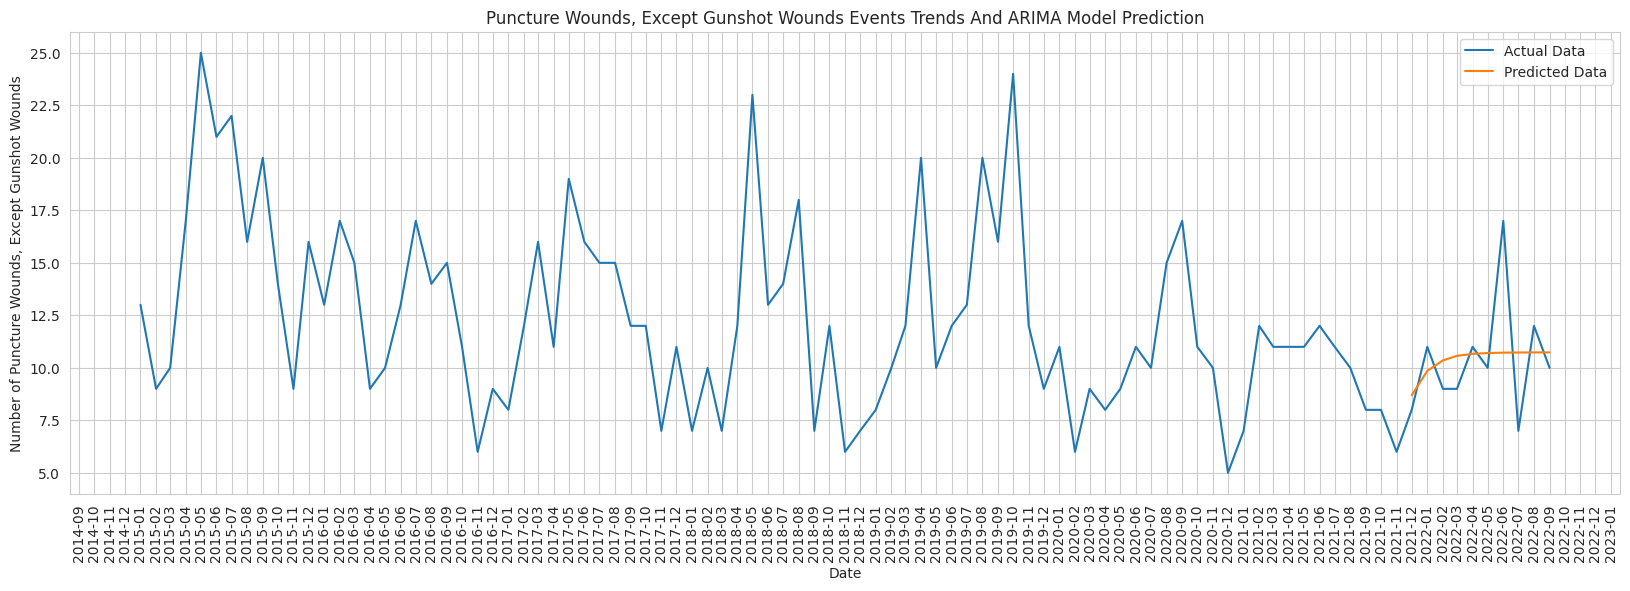

Mean Absolute Error: 1.7815227909058797
Mean Squared Error: 6.217204633977722
Root Mean Squared Error: 2.4934322998585148
R-squared: 0.09
MAPE: 16.98%
Theil's U statistic: 0.5575484119777279


In [33]:
from statsmodels.tsa.arima.model import ARIMA

PWGW = data[data['NatureTitle'] == 'Puncture wounds, except gunshot wounds']
PWGW['EventDate'] = pd.to_datetime(PWGW['EventDate'])
monthly_counts = PWGW.groupby(PWGW['EventDate'].dt.to_period('M')).size()

# Prepare the training and test data
train_size = int(len(monthly_counts) * 0.9)
train_data = monthly_counts[:train_size]
test_data = monthly_counts[train_size:]

# Create the ARIMA model and fit it
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Prediction and Plot
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

from matplotlib.dates import MonthLocator, DateFormatter

x_actual = monthly_counts.index.to_timestamp()
x_pred = predictions.index.to_timestamp()

plt.figure(figsize=(20, 6))
sns.set_style('whitegrid')
plt.plot(x_actual, monthly_counts, label='Actual Data')
plt.plot(x_pred, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Number of Puncture Wounds, Except Gunshot Wounds')
plt.title('Puncture Wounds, Except Gunshot Wounds Events Trends And ARIMA Model Prediction')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

plt.show()

# Evaluations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
mse_model = mean_squared_error(test_data, predictions)
mse_naive = mean_squared_error(test_data, np.roll(test_data, 1))
theil_u = np.sqrt(mse_model / mse_naive)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared: {:.2f}'.format(r2))
print('MAPE: {:.2f}%'.format(mape * 100))
print("Theil's U statistic:", theil_u)

# End Of Part 4